<a href="https://colab.research.google.com/github/Ashwini5737/AdultSalaryClassifier/blob/main/R_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Store Sales Forecasting Data Overview**

  In this dataset, you will predict sales for various product families sold at Favorita stores in Ecuador. The training data includes dates, store and product information, promotions, and sales figures. Several supplementary files provide additional context to enhance model building.

  **Dataset Files and Descriptions:**

  *train.csv:* Contains time series data with the following fields:

  *store_nbr:* Identifier for the store.

  *family:* Type of product sold.

  *sales:* Total sales for a product family at a store on a given date, including fractional values.

  *onpromotion:* Number of items in a product family that were on promotion.

  *stores.csv:* Metadata about stores, including city, state, type, and cluster.

  *oil.csv:* Daily oil prices, significant due to Ecuador's dependency on oil.

  *holidays_events.csv:* Information on holidays and events, including:


  *   transferred: Indicates if a holiday was officially moved to another date.
  *   Types of days include Bridge (extra day off) and Work Day (compensatory working day).
  *   Additional holidays for events like Christmas.

**Set the computational backend engine for deep learning to Theano in R.**

In [5]:
backend_engine <- "theano"  # Change this to "theano" or "cntk" if desired

**Install and load required packages, and set Keras backend to Theano.**


In [ ]:
if (!require(e1071)) {
  install.packages("e1071")
}
if (!require(randomForest)){
  install.packages('randomForest')
}
if(!require(forecast)){
  install.packages('forecast')
}

install.packages("reticulate")
if(!require(keras)){
  install.packages('keras')
}
if(!require(tensorflow)){
  install.packages('tensorflow')
}

if(!require(xgboost)){
  install.packages('xgboost')
}

Loading required package: e1071

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘e1071’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’


Loading required package: randomForest

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘randomForest’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: forecast

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘forecast’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘Rcpp’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


Installing pac

In [6]:
# Install all required packages
Sys.setenv(KERAS_BACKEND = backend_engine)
library(dplyr)
library(tidyr)
library(readr)
library(randomForest)
library(e1071)
library(reticulate)
library(forecast)
library(xgboost)
library(keras)
library(tensorflow)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




ERROR: Error in library(randomForest): there is no package called ‘randomForest’


**Read data from csv files**

In [3]:
# Read Data
data_df <- read_csv("/content/train.csv")
oil_df <- read_csv("/content/oil.csv")
stores_df <- read_csv("/content/stores.csv")
transactions_df <- read_csv("/content/transactions.csv")
hoildays_df <- read_csv("/content/holidays_events.csv")

ERROR: Error in read_csv("/content/train.csv"): could not find function "read_csv"


In [2]:
# Remove NA values
data_df <- na.omit(data_df)
oil_df <- na.omit(oil_df)
stores_df <- na.omit(stores_df)
transactions_df <- na.omit(transactions_df)
holidays_df <- na.omit(holidays_df)


ERROR: Error in eval(expr, envir, enclos): object 'data_df' not found


In [ ]:
# Convert date column to Date type
data_df$date <- as.Date(data_df$date)

In [ ]:
# Merge Data
merged_data_df <- data_df %>%
  left_join(oil_df, by = "date") %>%
  left_join(stores_df, by = "store_nbr") %>%
  left_join(transactions_df, by = c("store_nbr", "date"))
  left_join(holidays_df, by = c("date"))


In [ ]:
# Reduce size of merged data sets
merged_data_df <- sample_n(merged_data_df, 100)

In [ ]:
# Handling Missing Values
merged_data_df[is.na(merged_data_df)] <- 0

In [ ]:
# Split data into train and validation sets
set.seed(42)
train_indices <- sample(1:nrow(merged_data_df), 0.8 * nrow(merged_data_df))
train_data <- merged_data_df[train_indices, ]
validation_data <- merged_data_df[-train_indices, ]

In [ ]:
# Preparing Data for Random Forest
X_train <- train_data %>%
  dplyr::select(-c(date, sales)) %>%
  mutate(across(where(is.character), as.factor)) %>%
  mutate(across(where(is.factor), as.numeric))

y_train <- train_data$sales

X_val <- validation_data %>%
  dplyr::select(-c(date, sales)) %>%
  mutate(across(where(is.character), as.factor)) %>%
  mutate(across(where(is.factor), as.numeric))

y_val <- validation_data$sales

In [ ]:
# Feature Importance for Random Forest
rf_feature_importance <- importance(rf_model, type = 1)

In [ ]:
# Print Feature Importance for Random Forest
print("Random Forest Feature Importance:")
print(rf_feature_importance)

In [ ]:
# Plot Feature Importance for Random Forest
varImpPlot(rf_model)

In [ ]:
# Random Forest Model
rf_model <- randomForest(
  x = X_train,
  y = y_train,
  ntree = 500,
  mtry = sqrt(ncol(X_train)),
  importance = TRUE
)

xgb_feature_importance <- xgb.importance(colnames(X_train), model = xgb_model)

In [ ]:
# Print Feature Importance for XGBoost
print("XGBoost Feature Importance:")
print(xgb_feature_importance)
importance_matrix <- xgb.importance(colnames(X_train), model = xgb_model)
xgb.plot.importance(importance_matrix)

In [ ]:
# XGBoost Model
dtrain <- xgb.DMatrix(data = as.matrix(X_train), label = y_train)
dval <- xgb.DMatrix(data = as.matrix(X_val), label = y_val)

params <- list(
  objective = "reg:squarederror",
  eval_metric = "rmse"
)

xgb_model <- xgboost(params = params, data = dtrain, nrounds = 100)


In [ ]:
# Autocorrelation and Partial Autocorrelation Analysis for SARIMA
acf_sales <- acf(train_data$sales, lag.max = 50)
pacf_sales <- pacf(train_data$sales, lag.max = 50)

In [ ]:
# Plot Autocorrelation and Partial Autocorrelation Functions
par(mfrow=c(1,2))
plot(acf_sales, main="Autocorrelation Function (ACF) of Sales")
plot(pacf_sales, main="Partial Autocorrelation Function (PACF) of Sales")

In [ ]:
# Get the output of the LSTM layer
lstm_layer_output <- predict(lstm_model, X_train_reshaped)

In [ ]:
# Plot activations of the LSTM layer
plot(lstm_layer_output)


In [ ]:
# LSTM Model
X_train_matrix <- as.matrix(X_train)
X_val_matrix <- as.matrix(X_val)

lstm_model <- keras_model_sequential()
lstm_model %>%
  layer_lstm(units = 50, input_shape = c(ncol(X_train_matrix), 1)) %>%
  layer_dense(units = 1)

lstm_model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(),
  metrics = c("mean_absolute_error")
)

X_train_reshaped <- array_reshape(X_train_matrix, c(nrow(X_train_matrix), ncol(X_train_matrix), 1))
X_val_reshaped <- array_reshape(X_val_matrix, c(nrow(X_val_matrix), ncol(X_val_matrix), 1))

history <- lstm_model %>% fit(
  X_train_reshaped, y_train,
  epochs = 50, batch_size = 32,
  validation_data = list(X_val_reshaped, y_val)
)

In [ ]:
# SARIMA Model
sarima_model <- auto.arima(y_train)


In [ ]:
# Random Forest Predictions
predictions_rf <- predict(rf_model, X_val)

# XGBoost Predictions
predictions_xgb <- predict(xgb_model, dval)

# LSTM Predictions
predictions_lstm <- lstm_model %>% predict(X_val_reshaped)

# SARIMA Predictions
predictions_sarima <- forecast(sarima_model, h = nrow(validation_data))$mean

In [ ]:
# Calculate Metrics for each model
mse_rf <- mean((predictions_rf - y_val)^2)
mse_xgb <- mean((predictions_xgb - y_val)^2)
mse_lstm <- mean((predictions_lstm - y_val)^2)


rmse_rf <- sqrt(mean((predictions_rf - y_val)^2))
rmse_xgb <- sqrt(mean((predictions_xgb - y_val)^2))
rmse_lstm <- sqrt(mean((predictions_lstm - y_val)^2))

mae_rf <- mean(abs(predictions_rf - y_val))
mae_xgb <- mean(abs(predictions_xgb - y_val))
mae_lstm <- mean(abs(predictions_lstm - y_val))

r_squared_rf <- 1 - (sum((y_val - predictions_rf)^2) / sum((y_val - mean(y_val))^2))
r_squared_xgb <- 1 - (sum((y_val - predictions_xgb)^2) / sum((y_val - mean(y_val))^2))
r_squared_lstm <- 1 - (sum((y_val - predictions_lstm)^2) / sum((y_val - mean(y_val))^2))


mse_sarima <- mean((predictions_sarima - y_val)^2)
rmse_sarima <- sqrt(mean((predictions_sarima - y_val)^2))
mae_sarima <- mean(abs(predictions_sarima - y_val))
r_squared_sarima <- 1 - (sum((y_val - predictions_sarima)^2) / sum((y_val - mean(y_val))^2))

In [ ]:
# Output the results
print("Random Forest Metrics:")
print(paste("MSE:", mse_rf))
print(paste("RMSE:", rmse_rf))
print(paste("MAE:", mae_rf))
print(paste("R-squared:", r_squared_rf))

print("XGBoost Metrics:")
print(paste("MSE:", mse_xgb))
print(paste("RMSE:", rmse_xgb))
print(paste("MAE:", mae_xgb))
print(paste("R-squared:", r_squared_xgb))

print("LSTM Metrics:")
print(paste("MSE:", mse_lstm))
print(paste("RMSE:", rmse_lstm))
print(paste("MAE:", mae_lstm))
print(paste("R-squared:", r_squared_lstm))

print("SARIMA Metrics:")
print(paste("MSE:", mse_sarima))
print(paste("RMSE:", rmse_sarima))
print(paste("MAE:", mae_sarima))
print(paste("R-squared:", r_squared_sarima))

In [ ]:
# Add SARIMA results to the summary table
summary_table <- data.frame(
  Model = c("Random-Forest", "XGBoost", "LSTM", "SARIMA"),
  MSE = c(mean((predictions_rf - y_val)^2), mean((predictions_xgb - y_val)^2), mean((predictions_lstm - y_val)^2), mse_sarima),
  RMSE = c(sqrt(mean((predictions_rf - y_val)^2)), sqrt(mean((predictions_xgb - y_val)^2)), sqrt(mean((predictions_lstm - y_val)^2)), rmse_sarima),
  MAE = c(mean(abs(predictions_rf - y_val)), mean(abs(predictions_xgb - y_val)), mean(abs(predictions_lstm - y_val)), mae_sarima),
  R_squared = c(1 - (sum((y_val - predictions_rf)^2) / sum((y_val - mean(y_val))^2)), 1 - (sum((y_val - predictions_xgb)^2) / sum((y_val - mean(y_val))^2)), 1 - (sum((y_val - predictions_lstm)^2) / sum((y_val - mean(y_val))^2)), r_squared_sarima)
)

# Print the summary table
print(summary_table)

In [ ]:
# Plot showing values for all models
par(mfrow=c(2,2))
barplot(summary_table$MSE, main="Mean Squared Error", names.arg=summary_table$Model, col="lightblue")
barplot(summary_table$RMSE, main="Root Mean Squared Error", names.arg=summary_table$Model, col="lightgreen")
barplot(summary_table$MAE, main="Mean Absolute Error", names.arg=summary_table$Model, col="lightcoral")
barplot(summary_table$R_squared, main="R-squared", names.arg=summary_table$Model, col="lightgray")

In [ ]:
# Plotting predicted vs actual values for all models
par(mfrow=c(2, 2))

In [ ]:
# Random Forest
plot(y_val, predictions_rf, main = "Random Forest Predictions", xlab = "Actual Sales", ylab = "Predicted Sales", col = "blue")
abline(0, 1, col = "red")

# XGBoost
plot(y_val, predictions_xgb, main = "XGBoost Predictions", xlab = "Actual Sales", ylab = "Predicted Sales", col = "green")
abline(0, 1, col = "red")

# LSTM
plot(y_val, predictions_lstm, main = "LSTM Predictions", xlab = "Actual Sales", ylab = "Predicted Sales", col = "purple")
abline(0, 1, col = "red")

# SARIMA
plot(y_val, predictions_sarima, main = "SARIMA Predictions", xlab = "Actual Sales", ylab = "Predicted Sales", col = "orange")
abline(0, 1, col = "red")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Rows: 3000888 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): family
dbl  (4): id, store_nbr, sales, onpromotion
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 28512 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): family
dbl  (3): id, store_nbr, onpromotion
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1218 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): dcoilwtico
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this d

[1] "Random Forest Feature Importance:"
                %IncMSE
id            0.6245352
store_nbr     2.3509712
family        1.6983210
onpromotion  12.1872105
dcoilwtico    3.0595478
city          0.3118557
state         0.1209278
type          2.3402424
cluster       1.4092441
transactions  7.3745795
[1] "XGBoost Feature Importance:"
         Feature         Gain      Cover  Frequency
          <char>        <num>      <num>      <num>
 1: transactions 8.264532e-01 0.30887886 0.17921147
 2:  onpromotion 1.308373e-01 0.08476077 0.03635433
 3:   dcoilwtico 1.777703e-02 0.08389767 0.08704557
 4:           id 9.490375e-03 0.16737485 0.32206861
 5:       family 8.077848e-03 0.15360953 0.14746544
 6:    store_nbr 3.776476e-03 0.06174479 0.09677419
 7:        state 1.832799e-03 0.05495065 0.04761905
 8:         city 1.678921e-03 0.03642721 0.03584229
 9:         type 4.371672e-05 0.01821361 0.01894521
10:      cluster 3.235658e-05 0.03014208 0.02867384


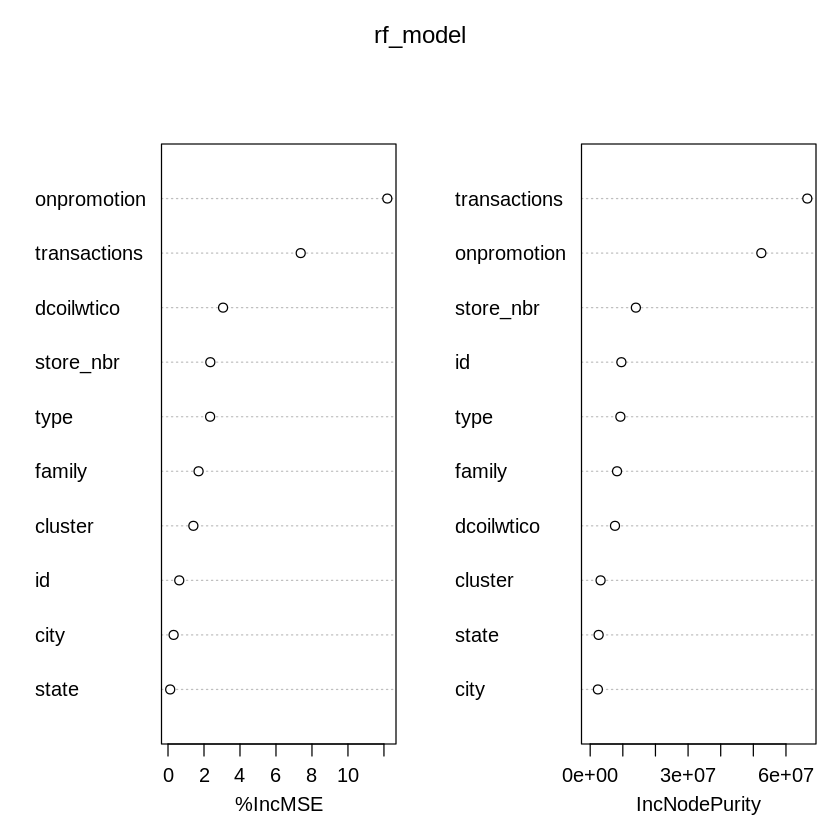

[1]	train-rmse:1228.123631 
[2]	train-rmse:1041.688850 
[3]	train-rmse:884.060628 
[4]	train-rmse:750.703628 
[5]	train-rmse:637.688932 
[6]	train-rmse:541.880088 
[7]	train-rmse:460.719498 
[8]	train-rmse:390.977034 
[9]	train-rmse:332.440318 
[10]	train-rmse:282.372599 
[11]	train-rmse:240.374741 
[12]	train-rmse:204.839502 
[13]	train-rmse:174.466452 
[14]	train-rmse:148.807585 
[15]	train-rmse:127.058847 
[16]	train-rmse:108.746071 
[17]	train-rmse:93.042804 
[18]	train-rmse:79.655428 
[19]	train-rmse:68.435015 
[20]	train-rmse:58.666357 
[21]	train-rmse:50.744285 
[22]	train-rmse:43.795666 
[23]	train-rmse:38.218141 
[24]	train-rmse:32.789628 
[25]	train-rmse:28.391912 
[26]	train-rmse:24.561839 
[27]	train-rmse:21.406162 
[28]	train-rmse:19.054277 
[29]	train-rmse:16.768710 
[30]	train-rmse:14.761992 
[31]	train-rmse:13.217440 
[32]	train-rmse:11.617449 
[33]	train-rmse:10.493109 
[34]	train-rmse:9.495552 
[35]	train-rmse:8.462494 
[36]	train-rmse:7.553743 
[37]	train-rmse:6.8769

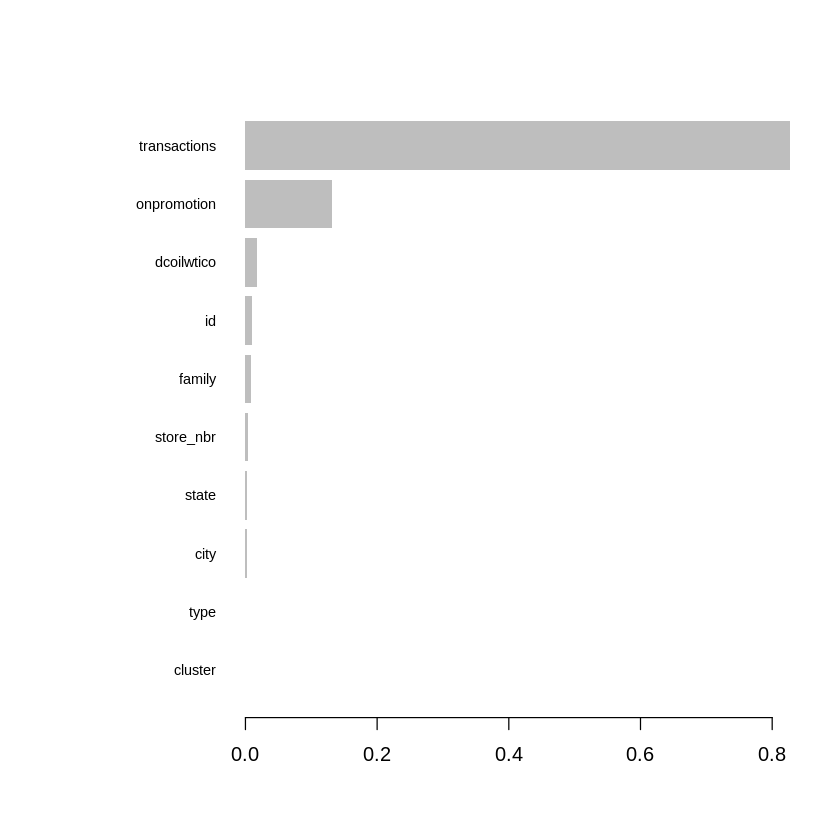

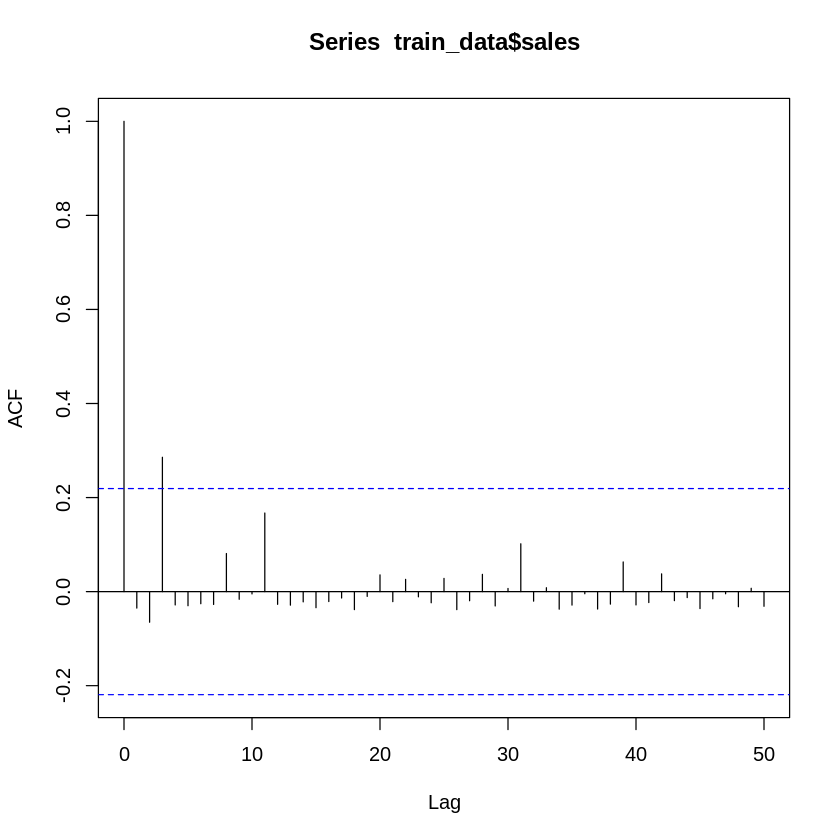

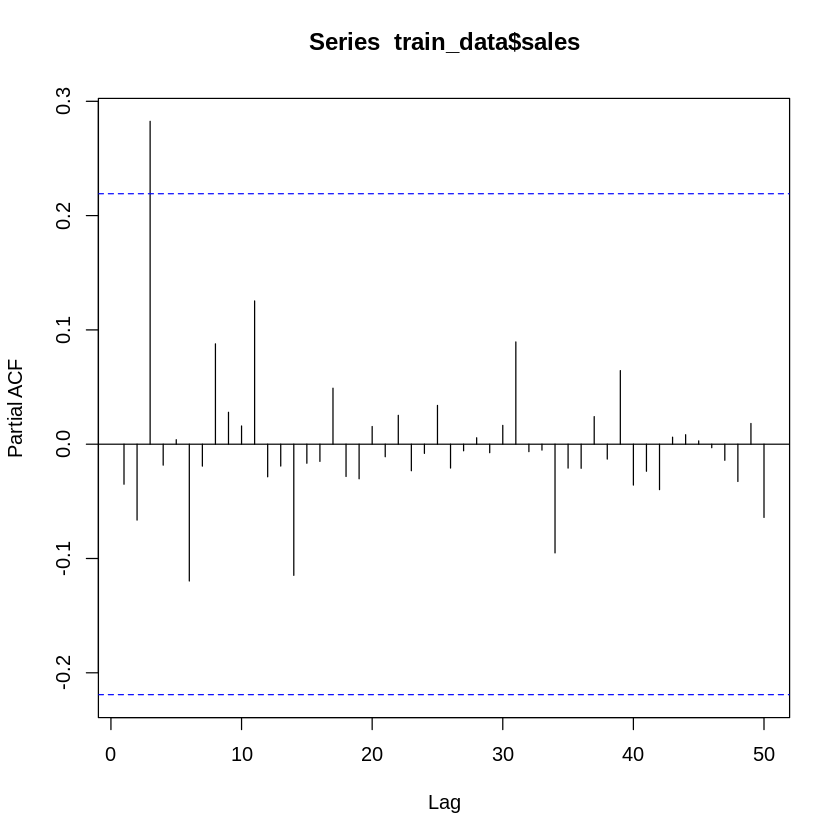

[1] "Random Forest Metrics:"
[1] "MSE: 239751.865339073"
[1] "RMSE: 489.644631686157"
[1] "MAE: 340.334947723667"
[1] "R-squared: -0.741943468347258"
[1] "XGBoost Metrics:"
[1] "MSE: 199912.405507104"
[1] "RMSE: 447.115651154267"
[1] "MAE: 300.46829787693"
[1] "R-squared: -0.452485504219913"
[1] "LSTM Metrics:"
[1] "MSE: 181415.861691605"
[1] "RMSE: 425.929409282343"
[1] "MAE: 214.470750768995"
[1] "R-squared: -0.318096836833159"
[1] "SARIMA Metrics:"
[1] "MSE: 158432.694559245"
[1] "RMSE: 398.036046808885"
[1] "MAE: 247.757561967584"
[1] "R-squared: -0.151110115743302"
          Model      MSE     RMSE      MAE  R_squared
1 Random-Forest 239751.9 489.6446 340.3349 -0.7419435
2       XGBoost 199912.4 447.1157 300.4683 -0.4524855
3          LSTM 181415.9 425.9294 214.4708 -0.3180968
4        SARIMA 158432.7 398.0360 247.7576 -0.1511101


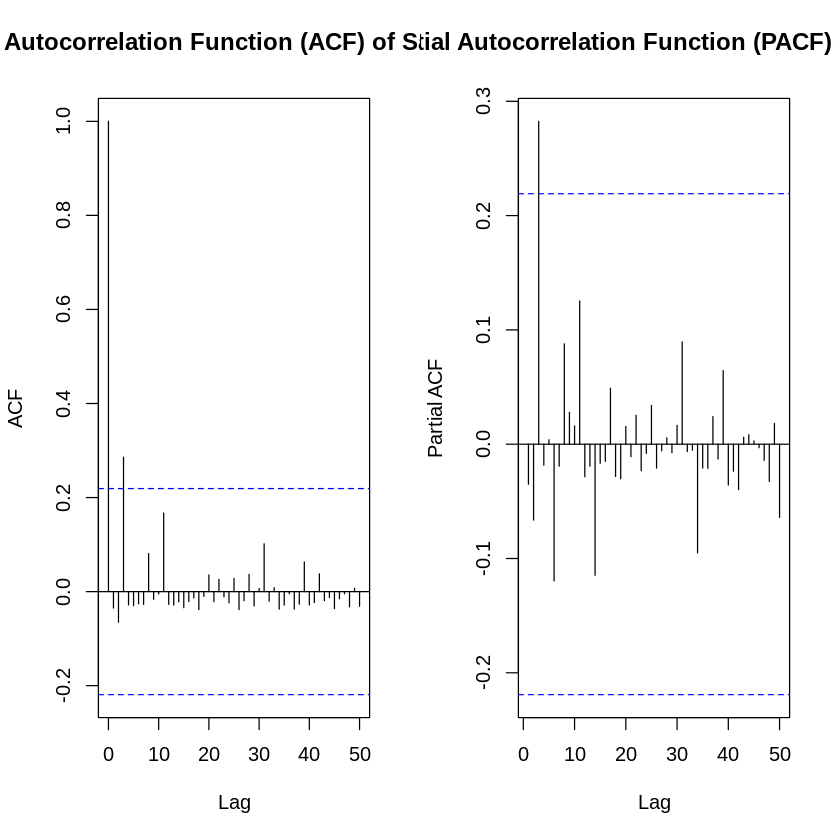

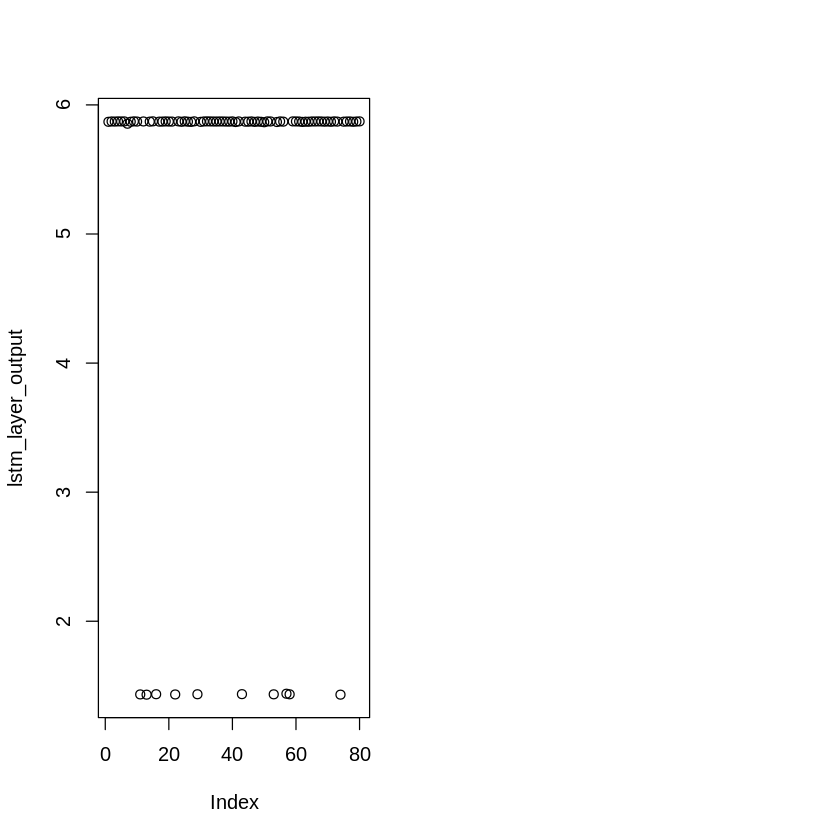

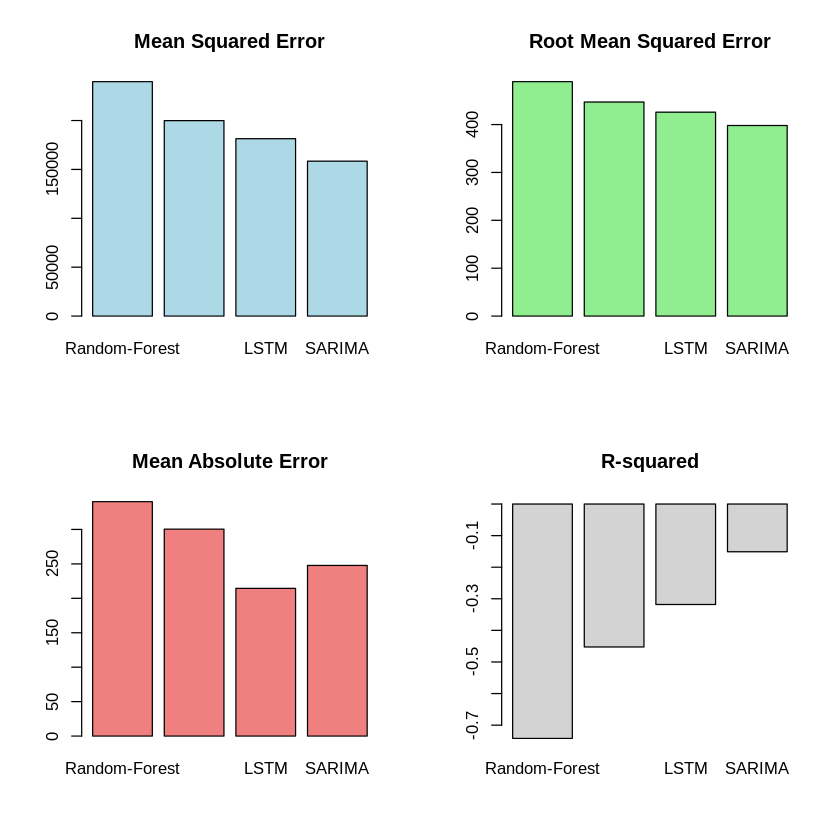

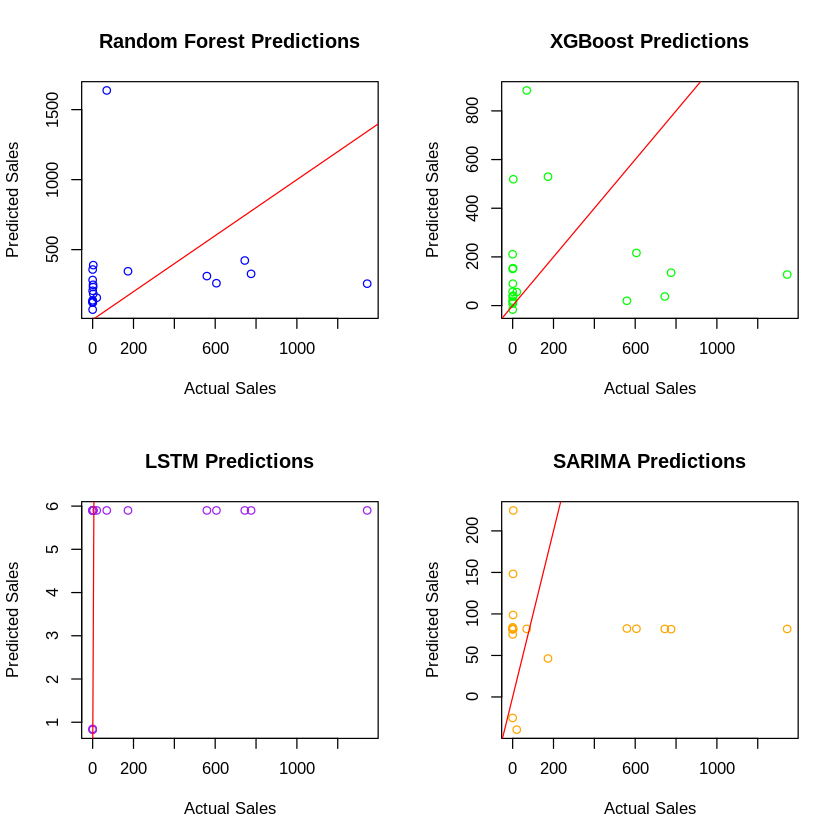

In [ ]:




# Create a summary table for all models
#summary_table <- data.frame(
#  Model = c("Random Forest", "XGBoost", "LSTM"),
#  MSE = c(mse_rf, mse_xgb, mse_lstm),
#  RMSE = c(rmse_rf, rmse_xgb, rmse_lstm),
#  MAE = c(mae_rf, mae_xgb, mae_lstm),
#  R_squared = c(r_squared_rf, r_squared_xgb, r_squared_lstm)
#)

# Output SARIMA Metrics



# Plot histograms for SARIMA predictions
#hist(predictions_sarima, main = "SARIMA Predictions", xlab = "Predicted Sales", col = "lightblue")

In [ ]:
if (!requireNamespace("e1071", quietly = TRUE)) {
  install.packages("e1071")  # Install the package if not already installed
} else {
  # If package is installed, print its version
  package_version <- packageVersion("e1071")
  print(paste("e1071 package version:", package_version))
}

[1] "e1071 package version: 1.7.14"
